In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import tensorboardX

from freesound.utils.general import seed_everything, setup_tboard_writer
from freesound.utils.lwlwrap import calculate_per_class_lwlrap
from freesound.spec_augment import augment_spectrogram as augspecorig
from freesound.imaug_seqs import imgaug_seqs_dict
from freesound.archis.large import Classifier

import bz2
from freesound.preprocessor import Preprocessor
import pylab as plt
from pathlib import Path
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

## PARAMS ##
RUN_NAME = 'no_mixup_tf_2048'
SEED = 2019
PREPROCESSOR_CONFIG_NAME = 'tf_2048'
RANDOM_VOLUME = 0.8
SPEC_AUGMENT_PROB = 0.25
MIXUP_ALPHA = 0.0
IMGAUG_SEQ = 'default'
BATCH_SIZE = 64
LR = 3e-3
LR_MIN = 1e-5
T_MAX = 10
NUM_EPOCHS = 300
############

preprocessor_config_path = 'config/preprocessing/{}.yaml'.format(PREPROCESSOR_CONFIG_NAME)
augment_spectrogram = lambda x: augspecorig(x, RANDOM_VOLUME, SPEC_AUGMENT_PROB)

In [4]:
seed_everything(SEED)
tboard_writer, tboard_log_dir = setup_tboard_writer(RUN_NAME)

In [5]:
N_JOBS = cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)

In [6]:
dataset_dir = Path(os.environ['FS_INPUTS_BASE']) / 'freesound-audio-tagging-2019'

In [7]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    'train_noisy': dataset_dir / 'train_noisy.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
    'test': dataset_dir / 'test.csv',
}

In [8]:
df_train_curated = pd.read_csv(csvs['train_curated'])
df_train_noisy = pd.read_csv(csvs['train_noisy'])
df_sample = pd.read_csv(csvs['sample_submission'])

In [9]:
labels = df_sample.columns[1:].tolist()

In [10]:
num_classes = len(labels)

In [11]:
def df_to_dummies(df):
    y_train = df['labels'].str.get_dummies(sep=',').values.astype(np.float32)
    assert y_train.shape[1] == 80
    return y_train

def df_to_x(df):
    return df.fname.values

def df_to_xy(df):
    y = df_to_dummies(df)
    x = df_to_x(df)
    assert len(x) == len(y)
    return x, y

In [12]:
x_train, y_train = df_to_xy(df_train_curated)
x_train_noisy, y_train_noisy = df_to_xy(df_train_noisy)
x_test = df_to_x(df_sample)
all_wavnames = np.append(x_train, x_train_noisy)

In [13]:
preproc = Preprocessor(preprocessor_config_path)
preproc.fill_cache(all_wavnames)

Loading took 4.315376281738281e-05 seconds


/home/liam/freesoundkaggle/src/freesound/data_utils/audio_transforms_tf.py:55: RuntimeWarning: divide by zero encountered in log10
  S = np.maximum(-80., 10 * np.log10(S + 1e-80) - 10 * 3.4)


In [14]:
preproc.save_cache()

In [15]:
from tensorflow.python.eager import context
context.context()._clear_caches()  # Increasing memory and PyObject count without this
import gc
gc.collect()
print(len(gc.get_objects()))

292463


In [16]:
seq = imgaug_seqs_dict[IMGAUG_SEQ]

In [17]:
def get_noisy_img_and_label(pp):
    idx = np.random.randint(len(x_train_noisy))
    return pp[x_train_noisy[idx]], y_train_noisy[idx]
        

class FATTrainDataset(Dataset):
    def __init__(self, preproc, fnames, labels, seq, mixup_alpha=MIXUP_ALPHA, is_training=True,
                 desired_length=128, no_labels=False, return_fnames=False, return_crop=False,
                 no_unlabeled=False, K=2):
        super().__init__()
        self.preproc = preproc
        self.fnames = fnames
        self.labels = labels
        self.seq = seq
        self.mixup_alpha = mixup_alpha
        self.is_training = is_training
        self.desired_length = desired_length
        self.no_labels = no_labels
        self.return_fnames = return_fnames
        self.return_crop = return_crop

        self.transforms = transforms.ToTensor()
        self.no_unlabeled = no_unlabeled
        self.K = K
        
    def __len__(self):
        return len(self.fnames)
    
    def crop_img(self, image):
        time_dim = image.shape[1]
        diff = time_dim - self.desired_length
        if diff > 0:
            crop = random.randint(0, diff)
            self.last_crop = crop
            image = image[:, crop:crop + self.desired_length]
        elif diff < 0:
            tmp = np.zeros([image.shape[0], self.desired_length, *image.shape[2:]],
                           dtype=image.dtype)
            start = random.randint(0, -diff)
            self.last_crop = start
            tmp[:, start:start + image.shape[1]] = image
            image = tmp
        return image
    
    def prep_img(self, image):
        if self.is_training:
            image = self.seq.augment_image(image)
        image = self.transforms(image)
        if self.is_training:
            image = augment_spectrogram(image)
        return image.div_(255)
    
    def preprep_img(self, image):
        if image.shape[0] == 1:
            image = np.tile(image, [3, 1, 1])
        image = np.transpose(image, [1, 2, 0])
        return image
            
    def _get_single_unlabled_img(self):
        u, _ = get_noisy_img_and_label(self.preproc)
        u = self.crop_img(self.preprep_img(u))
        return u
        
    def __getitem__(self, idx):
        image = self.preproc[self.fnames[idx]]
        image = self.preprep_img(image)
        if not self.no_labels:
            label = self.labels[idx]
        image = self.crop_img(image)
        if self.is_training and self.mixup_alpha:
            mixup_p = np.random.beta(self.mixup_alpha + 1, self.mixup_alpha)
            if mixup_p < 0.98:  # save compute when mixup barely has effect
                oth_image, oth_label = get_noisy_img_and_label(self.preproc)
                oth_image = self.preprep_img(oth_image)
                oth_image = self.crop_img(oth_image)
                image = mixup_p * image + (1 - mixup_p) * oth_image
                image = image.round().astype(np.uint8)
                label = label + (1 - mixup_p) * oth_label
                label = np.clip(label, 0.0, 1.0)
        image = self.prep_img(image)
        ret = []
        ret += [image]
        if self.return_fnames:
            ret += [self.fnames[idx]]
        if self.return_crop:
            ret += [self.last_crop]
        if self.no_labels:
            return tuple(ret)
        ret += [torch.from_numpy(label).float()]
        if self.no_unlabeled:
            return tuple(ret)
        u = self._get_single_unlabled_img()
        # multiple augmentations of same img crop
        unlabeled_img = torch.cat([self.prep_img(u.copy()) for i in range(self.K)], 0)
        ret += [unlabeled_img]
        return tuple(ret)

In [18]:
UNSUP_LOSS_WEIGHT = 0.0
UNSUP_RAMP_START_EPOCH = 90
UNSUP_RAMP_END_EPOCH = 130

def get_unsup_loss_weight(epoch):
    e = epoch + 1
    if e < UNSUP_RAMP_START_EPOCH:
        return 0.0
    if e >= UNSUP_RAMP_END_EPOCH:
        return UNSUP_LOSS_WEIGHT
    wt = (e - UNSUP_RAMP_START_EPOCH) / (UNSUP_RAMP_END_EPOCH - UNSUP_RAMP_START_EPOCH)
    return wt * UNSUP_LOSS_WEIGHT

In [19]:
batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE
lr = LR
lr_min = LR_MIN
t_max = T_MAX

x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.02, random_state=SEED)

In [20]:
train_dataset = FATTrainDataset(preproc, x_trn, y_trn, seq=seq, mixup_alpha=MIXUP_ALPHA, is_training=True, no_unlabeled=(UNSUP_LOSS_WEIGHT<=0))
valid_dataset = FATTrainDataset(preproc, x_val, y_val, seq=None, is_training=False, no_unlabeled=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)

In [21]:
import torch.nn.functional as F

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model = Classifier(num_classes=num_classes)
# model = ClassifierPhase2(model)
model = model.cuda()
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=lr_min)
criterion = nn.BCEWithLogitsLoss().cuda()
# unsup_criterion = F.binary_cross_entropy
unsup_criterion = F.mse_loss

In [22]:
# for i in range(90):
#     scheduler.step()
# model.load_state_dict(torch.load(Path('ckpts') / 'mixmatch_unsupwt0.1/' / 'weight_epoch90.pt'))
model = nn.DataParallel(model)

In [23]:
epoch = 0
num_epochs = NUM_EPOCHS

In [24]:
def sharpen(logit, T):
    return torch.sigmoid(T * logit)

def sharpened_guess(ub, model, K, T=0.5):
    with torch.no_grad():
        was_training = model.training
        model.eval()
        pr = torch.sigmoid(model(ub))  # shape = [B*K, 80]
        guess = pr.view(K, pr.shape[0] // K, -1).mean(0).data
        out = sharpen(guess, T).repeat([K, 1])
        if was_training:
            model.train()
        return out

In [25]:
def mixup_mod(x1, x2, y1, y2, alpha):
    # lambda is a reserved word in python, substituting by beta
    beta = np.random.beta(alpha, alpha) 
    beta = np.amax([beta, 1 - beta])
    x = beta * x1 + (1 - beta) * x2
    y = beta * y1 + (1 - beta) * y2
    return x, y

def mixup(x, y, Ux, Uy, alpha=0.5):
    indices = torch.randperm(len(x) + len(Ux))[:len(Ux)]
    # MixUp
    Wx = torch.cat([Ux, x], dim=0)[indices]
    Wy = torch.cat([Uy, y], dim=0)[indices]
    U, q = mixup_mod(Wx, Ux, Wy, Uy, alpha)
    return U, q

In [26]:
num_epochs = 600

In [27]:
def is_interesting_epoch(epoch):
    epoch = epoch + 1
    if epoch // 10 % 2 == 1:
        if epoch - (10 * (epoch // 10)) < 5:
            return True
    return False

mb = master_bar(range(epoch, num_epochs))

for epoch in mb:
    start_time = time.time()
    model.train()
    avg_loss = 0.
    avg_loss_u = 0.

    for stuff in progress_bar(train_loader, parent=mb):
        if len(stuff) == 2:
            x_batch, y_batch = [i.cuda() for i in stuff]
        elif len(stuff) == 3:
            x_batch, y_batch, u_batch = [i.cuda() for i in stuff]

        preds = model(x_batch)
        loss_train = criterion(preds, y_batch)
        loss = torch.FloatTensor([0.0]).cuda()
        loss += loss_train
        
        unsup_loss_wt_now = get_unsup_loss_weight(epoch)
        if unsup_loss_wt_now > 0.0:
            h, w = u_batch.shape[-2:]
            u_batch = u_batch.view(batch_size, 2, 3, h, w).permute(1, 0, 2, 3, 4).contiguous().view(-1, 3, h, w)
            K = u_batch.shape[0] // batch_size
            guessed_sharpened_pu = sharpened_guess(u_batch, model, K)
            mixedup_x, mixedup_y = mixup(x_batch, y_batch, u_batch, guessed_sharpened_pu)
            mixedup_preds = model(mixedup_x)
            loss_unsup = unsup_criterion(torch.sigmoid(mixedup_preds), mixedup_y)
            loss += loss_unsup * unsup_loss_wt_now
            avg_loss_u += loss_unsup.item() / len(train_loader)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss_train.item() / len(train_loader)

    do_val = is_interesting_epoch(epoch)

    if do_val:
        model.eval()
        valid_preds = np.zeros((len(x_val), num_classes))
        avg_val_loss = 0.

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            preds = model(x_batch.cuda()).detach()
            loss = criterion(preds, y_batch.cuda())

            preds = torch.sigmoid(preds)
            valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()

            avg_val_loss += loss.item() / len(valid_loader)

        score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
        lwlrap = (score * weight).sum()

        if is_interesting_epoch(epoch):
            savedir = str(tboard_log_dir).replace('tboard', 'ckpts')
            if not os.path.exists(savedir):
                os.makedirs(savedir)
            torch.save(model.module.state_dict(), Path(savedir) / 'weight_epoch{}.pt'.format(epoch + 1))

        tboard_writer.add_scalar('metrics/avg_val_loss', avg_val_loss, epoch + 1)
        tboard_writer.add_scalar('metrics/val_lwlrap', lwlrap, epoch + 1)

    elapsed = time.time() - start_time

    scheduler.step()

    tboard_writer.add_scalar('metrics/avg_train_loss', avg_loss, epoch + 1)
    tboard_writer.add_scalar('metrics/avg_loss_u', avg_loss_u, epoch + 1)
    tboard_writer.add_scalar('meta/lr', get_lr(optimizer), epoch + 1)
    tboard_writer.add_scalar('meta/elapsed', elapsed, epoch + 1)

/home/liam/freesoundkaggle/src/freesound/spec_augment.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/home/liam/freesoundkaggle/src/freesound/spec_augment.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/home/liam/freesoundkaggle/src/freesound/spec_augment.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor(queries - floor, dtype=grid_type)
/home/liam/freesoundkaggle/src/freesound/spec_augment.p

KeyboardInterrupt: 

In [ ]:
preproc.save_cache

In [25]:
epoch = 517

In [62]:
def add_state_dict(a, b):
    for k in a:
        a[k] += b[k]
    return a

def load_state_dict_multi(path, ckpts=None):
    path = Path(path)
    if ckpts is None:
        ckpts = [i for i in os.listdir(path) if i.endswith('.pt') and 'best' not in i]
    ckpts = [i for i in ckpts if i.endswith('.pt') and 'best' not in i]
    print(len(ckpts), ckpts)
    num_ckpts = len(ckpts)
    state_dict_out = torch.load(path / ckpts[0])
    for ckpt in ckpts[1:]:
        state_dict_this = torch.load(path / ckpt)
        state_dict_out = add_state_dict(state_dict_out, state_dict_this)
    for k in state_dict_out:
        state_dict_out[k] /= num_ckpts
    return dict([(k.replace('module.', ''), state_dict_out[k]) for k in state_dict_out.keys()])

# After restart + skip cell above
model = Classifier(num_classes=num_classes)
savedir = Path('ckpts') / 'mixmatch2_go_unsuplosswt2_difftemp'
ckptfiles = [j for j in os.listdir(savedir) for i in range(425, 1000) if str(i) in j]
model.load_state_dict(load_state_dict_multi(savedir, ckptfiles))

30 ['weight_epoch514.pt', 'weight_epoch510.pt', 'weight_epoch551.pt', 'weight_epoch473.pt', 'weight_epoch531.pt', 'weight_epoch471.pt', 'weight_epoch470.pt', 'weight_epoch494.pt', 'weight_epoch434.pt', 'weight_epoch433.pt', 'weight_epoch512.pt', 'weight_epoch453.pt', 'weight_epoch541.pt', 'weight_epoch451.pt', 'weight_epoch561.pt', 'weight_epoch521.pt', 'weight_epoch511.pt', 'weight_epoch432.pt', 'weight_epoch431.pt', 'weight_epoch493.pt', 'weight_epoch474.pt', 'weight_epoch490.pt', 'weight_epoch430.pt', 'weight_epoch452.pt', 'weight_epoch492.pt', 'weight_epoch513.pt', 'weight_epoch454.pt', 'weight_epoch450.pt', 'weight_epoch491.pt', 'weight_epoch472.pt']


In [63]:
model = model.cuda()
model = nn.DataParallel(model)
optimizer = Adam(params=model.parameters(), lr=0.001, amsgrad=False)

In [28]:
from torch.optim import Adam, SGD
optimizer = SGD(params=model.parameters(), lr=0.001)

TypeError: __init__() got an unexpected keyword argument 'amsgrad'

In [38]:
from torch.optim import Adam, SGD
optimizer = SGD(params=model.parameters(), lr=0.01, momentum=0.9)

In [34]:
from liamlib.pytorch.utils import adjust_learning_rate

In [35]:
adjust_learning_rate(optimizer, 0.001)

0.001

['Toilet_flush', 'Accelerating_and_revving_and_vroom', 'Frying_(food)', 'Hiss', 'Hi-hat']


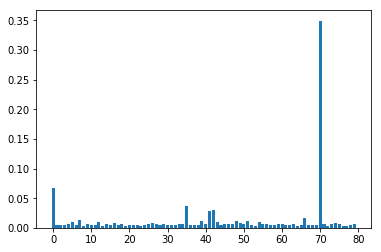

16.22


In [78]:
model.eval()
label = '01d2c640.wav'
label = '3f1ca1bb.wav'
img = preproc[label]
# img = valid_dataset.prep_img(valid_dataset.crop_img(valid_dataset.preprep_img(img)))
# out = torch.sigmoid(model(img.unsqueeze(0).cuda()))[0].data.cpu().numpy()

out = torch.mean(torch.stack([
    torch.sigmoid(model(valid_dataset.prep_img(valid_dataset.crop_img(valid_dataset.preprep_img(
        img))).unsqueeze(0).cuda()))[0] for i in range(30)], 0), 0).data.cpu().numpy()

print([labels[i] for i in reversed(out.argsort()[-5:])])
plt.bar(np.arange(80), out)
plt.show()

import IPython
from scipy.io.wavfile import read
fs_data_dir = Path(os.environ['FS_INPUTS_BASE']) / 'freesound-audio-tagging-2019/'
test_wavs_dir = fs_data_dir / 'test'
wavpath = str(test_wavs_dir / label)
wav = read(wavpath)[1]
print(wav.shape[0] / 44100)
IPython.display.Audio(wavpath)

array(['000ccb97.wav', '0012633b.wav', '001ed5f1.wav', ...,
       '4215309a.wav', '4248d196.wav', '42542036.wav'], dtype=object)

In [102]:
test_batch_size = 32
test_dataset = FATTrainDataset(preproc, x_test, None, seq=None, is_training=False, no_unlabeled=True, no_labels=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [108]:
def pred_test_set(model, test_loader, mb=None):
    model.eval()
    preds_all = None
    with torch.no_grad():
        for x_batch in progress_bar(test_loader, parent=mb):
            preds = torch.sigmoid(model(x_batch[0].cuda())).cpu()
            if preds_all is None:
                preds_all = preds
            else:
                preds_all = torch.cat([preds_all, preds], 0)
    return preds_all.numpy()

In [109]:
tta = 10
mb = master_bar(range(tta))
preds = None
for i in mb:
    if preds is None:
        preds = pred_test_set(test_loader, mb)
    else:
        preds += pred_test_set(test_loader, mb)

In [112]:
preds /= tta

In [115]:
df_sample[labels] = preds

In [126]:
df_sample.to_csv('submission.csv', index=False)